<a href="https://colab.research.google.com/github/kakafune2323/MTS_basicML/blob/main/HW_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F_%D0%B8_MSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация и MSE

Что произойдет если в задаче классификации при обучении применить MSE? вместо возни с log_loss, hinge_loss и прочим

In [1]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
rng = np.random.default_rng(seed=73)
class sgd_lecture_linear:
  def __init__(self, rng, MAX_ITER = 100_000):
    self.MAX_ITER = MAX_ITER
    self.w = None
    self.w0 = rng.normal()
    return

  def _f(self, x):
    assert len(x) == len(self.w)
    return np.dot(self.w, x) + self.w0

  def _der_loss(self, x, y, loss):
    if loss == 'MSE':
      return -(y - self._f(x)) * x

  def fit(self, X_train, y_train, loss = 'MSE'):
    self.w = rng.normal(size=X_train.shape[1])
    step = 0.01
    for k in range(self.MAX_ITER):
      rand_index = rng.integers(0, X_train.shape[0] - 1)
      x = np.array(X_train)[rand_index]
      y = np.array(y_train)[rand_index]
      if k % 10000 == 0:
         step = step / 2
      self.partial_fit(x, y, step, loss)

  def partial_fit(self, x, y, step = 0.01, loss = 'MSE'):
    if not self.w.any():
      self.w = rng.normal(size=len(x))
    dl = self._der_loss(x, y, loss)
    self.w -= step * dl
    self.w0 -= - step * (y - self._f(x))

  def predict_proba(self, x, loss = 'MSE'):
    x = np.array(x)
    preds = []
    pred_fuction = self._f
    for x_curr in x:
      preds.append(pred_fuction(x_curr))
    return preds

In [3]:
random_state = 73
x, y = make_classification(1_000, 7, random_state = random_state)
test_size = 0.3
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)

In [4]:
sgd = sgd_lecture_linear(rng)
sgd.fit(x_train, y_train)
preds = sgd.predict_proba(x_test)
print(f'{roc_auc_score(y_test, preds):.3f}')

0.978


Очень неплохо!

Сравним с Logistic Regression из sklearn (обучается на logloss)

In [5]:
lr = LogisticRegression(random_state = random_state)
lr.fit(x_train, y_train)
lr_preds = lr.predict_proba(x_test)[:, 1]
print(f'{roc_auc_score(y_test, lr_preds):.3f}')

0.981


Не сказать чтобы прямо сильно отличаются качеством!

Как же так? Мы же оптимизировали MSE -- а он для задач регресии!

Попробуем сломать!

Давайте заменим таргеты на -1 и 1 вместо 0 и 1

In [7]:
sgd = sgd_lecture_linear(rng)
sgd.fit(x_train, 2 * y_train - 1)
preds = sgd.predict_proba(x_test)
print(f'{roc_auc_score(2 * y_test - 1, preds):.3f}')

lr = LogisticRegression(random_state = random_state)
lr.fit(x_train, 2 * y_train - 1)
lr_preds = lr.predict_proba(x_test)[:, 1]
print(f'{roc_auc_score(2 * y_test - 1, lr_preds):.3f}')

0.978
0.981


Не сработало!

**Задание**       
А если заменить 0 и 1 на -10 и 10?



1.   Метрики изменятся
2.   Метрики не изменятся



In [9]:
# INSERT YOUR CODE HERE
y_train_transformed = 2 * y_train - 1
y_train_transformed = 10 * y_train_transformed

y_test_transformed = 2 * y_test - 1
y_test_transformed = 10 * y_test_transformed

sgd = sgd_lecture_linear(rng)
sgd.fit(x_train, y_train_transformed)
preds = sgd.predict_proba(x_test)
print(f'SGD with MSE on -10/10: {roc_auc_score(y_test_transformed, preds):.3f}')

lr = LogisticRegression(random_state=random_state)
lr.fit(x_train, y_train_transformed)
lr_preds = lr.predict_proba(x_test)[:, 1]
print(f'LogisticRegression on -10/10: {roc_auc_score(y_test_transformed, lr_preds):.3f}')

SGD with MSE on -10/10: 0.978
LogisticRegression on -10/10: 0.981


## То есть MSE вполне можно применять для классификации?

В целом да!     
Но мы потеряем некоторые хорошие свойства.     
Вспомним семинар -- оптимизация log_loss эквивалента максимизации правдоподобия, то есть получившиеся оценки это оценки вероятности

Что же нам напредсказывал SGD с MSE?

<Axes: >

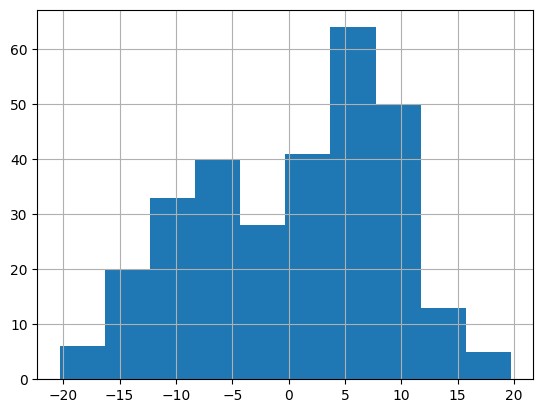

In [ ]:
import pandas as pd
pd.Series(preds).hist()

Сравните с предсказаниями логистической регресии

<Axes: >

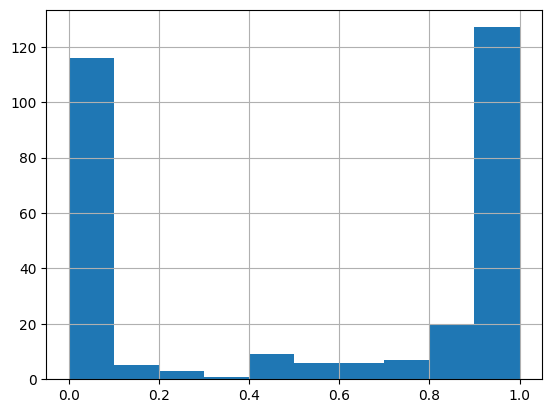

In [ ]:
pd.Series(lr_preds).hist()

То есть если логистическая регрессия предсказала, например, 0.9 -- в 9 случаях из 10 целевое событие произойдет

Это свойство логситической регрессии используется в моделях отклика в прайсинге, в оценке вероятности дефолта в рисках и пр.

Так что же, MSE вообще в классификации не использовать?

In [ ]:
from sklearn.calibration import calibration_curve, CalibrationDisplay

Для начала посмотрим на калибровочные кривые наших классификаторов

Они строятся так:
1.   Бьем пространство предсказаний на равные бины -- например, точки со скором от 0 до 0.2, от 0.2 до 0.4 и пр
2.   В каждом таком бине считаем средний скор (среднее значение всех предсказание, попавши в бин) -- это горизонтальная координата
3.   В каждом бине считаем долю единичек -- это вертикальная координата
4.   Получившиеся точки соединяем ломаной

При идеальной калибровке средний скор будет совпадать с концентрацией риска

Посмотрим как откалибрована логистическая регрессия

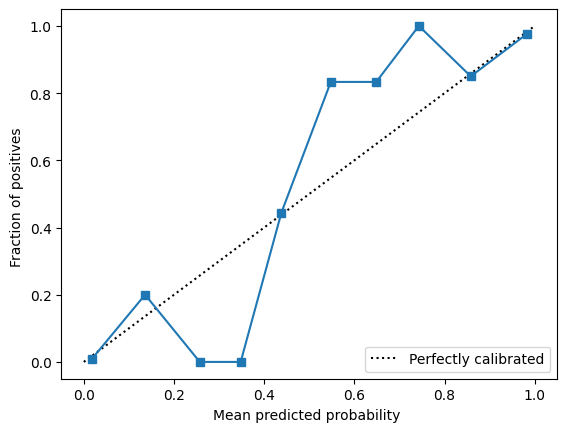

In [ ]:
prob_true, prob_pred = calibration_curve(y_test, lr_preds, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, lr_preds)
disp.plot()

Почему так получилось?

Смотрим на предыдущую картинку с распределением предиктов -- очень мало наблюдений попало в середину

Теперь как калиброван наш SGD с MSE, предварительно шкалируем предикты

In [ ]:
preds = (preds - min(preds)) / max(preds - min(preds))

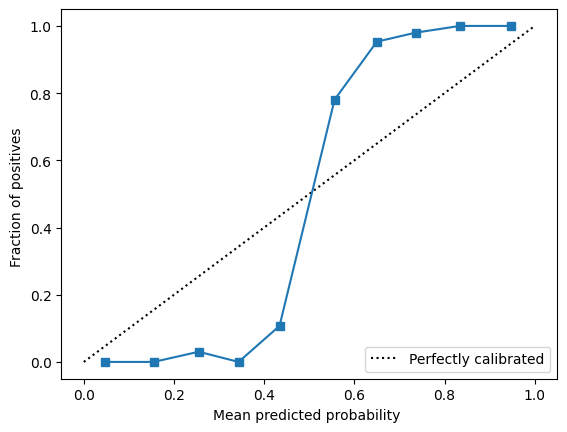

In [ ]:
prob_true, prob_pred = calibration_curve(y_test, preds, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, preds)
disp.plot()

Да уж! Вот здесь точно нельзя использовать предикты как вероятность!

Но это на глаз,  а как же количественно сравнить эти две кривые?

Для этого используется специальная метрика**:

$$
\text{Brier Score} = \frac{1}{N} \sum_{i=1}^{N} \left( y_i - p_i \right)^2
$$

** это вариант sklearn, в рисках применяется после разделения на 3 части -- аналогично разделению MSE на bias и variance -- мы еще поговорим об этом в семинаре по ансамблям

**Задание**:

Какой известный лосс вам напомнила эта формула

1.   huber loss
2.   MSE
3.   MSLE
4.   hinge loss
5.   log loss
6.   triplet loss



2.MSE

**Задание**:
В нашем примере как отличается Brier Score у логистической регрессии (LR) и SGD c MSE?

1.   У LR в три и более раз выше
2.   У LR выше от двух до трех раз
3.   Различия несущественны,  составляют не более 10%
4.   У LR ниже от двух до трех раз
5.   У LR в три и более раз ниже



In [11]:
from sklearn.metrics import brier_score_loss, mean_squared_error
from tabulate import tabulate
# INSERT YOUR CODE HERE
from sklearn.metrics import brier_score_loss

brier_lr = brier_score_loss(y_test, lr_preds)

preds_scaled = (preds - min(preds)) / (max(preds) - min(preds))
brier_sgd = brier_score_loss(y_test, preds_scaled)

print(f'Brier Score (Logistic Regression): {brier_lr:.5f}')
print(f'Brier Score (SGD with MSE): {brier_sgd:.5f}')

ratio = brier_sgd / brier_lr
print(f'Brier Score SGD / LR: {ratio:.2f}')

if ratio >= 3:
    comparison = 'У LR в три и более раз ниже'
elif ratio >= 2:
    comparison = 'У LR ниже от двух до трех раз'
elif ratio >= 1.1:
    comparison = 'У LR выше от двух до трех раз'
elif ratio > 0.9:
    comparison = 'Различия несущественны, составляют не более 10%'
elif ratio > 0.33:
    comparison = 'У LR выше от двух до трех раз'
else:
    comparison = 'У LR в три и более раз выше'

print(comparison)

Brier Score (Logistic Regression): 0.04218
Brier Score (SGD with MSE): 0.11749
Brier Score SGD / LR: 2.79
У LR ниже от двух до трех раз
